| Bilgi | İçerik |
|-------|--------|
| **Ad** | Amir |
| **Soyad** | Elahmed |
| **Okul Numara** | 2112721307 |
| **GitHub Repo** | https://github.com/Amirelahmed/CNN_siniflandirma |


**Model1 – Transfer Learning (VGG16)
Veri Seti Hazırlığı**

***Veri seti nasıl hazırlandı؟***

Telefon kamerası ile çekilmiş Taş ve Mermer sınıflarına ait özgün bir veri seti kullanılmıştır.
Görseller 128×128 boyutuna getirilmiş ve kurallara uygun şekilde klasörlenmiştir.

**Mimari Seçimi**

***Hangi model kullanıldı ve neden؟***


Model1’de ImageNet ağırlıklarıyla eğitilmiş VGG16 kullanılmıştır.
Küçük veri setlerinde güçlü özellik çıkarımı sağladığı için tercih edilmiştir.

**Transfer Learning**

***Transfer learning uygulandı mı؟***

Evet. VGG16’nın temel katmanları dondurulmuş, üst katmanlar veri setine göre eğitilmiştir.

.GlobalAveragePooling

.Dense

.Dropout

.Softmax

**Eğitim ve Test Sonuçları**

***Modelin performansı nedir؟***

Model 10 epoch eğitilmiş ve %83.33 test doğruluğu elde edilmiştir.
Accuracy ve loss grafiklerinde stabil bir öğrenme görülmüştür.

**Genel Değerlendirme**

***Model1 nasıl değerlendirilebilir؟***

Transfer learning sayesinde küçük ve özgün veri setinde dengeli ve kabul edilebilir bir performans elde edilmiştir.

1- Google Drive'ı bağlıyoruz

In [22]:
# Google Drive'ı Colab ortamına bağlıyoruz
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2- ZIP dosyasının Drive içindeki yolunu yazıyoruz

In [23]:
# Google Drive içindeki dataset ZIP dosyasının tam yolu
zip_path = "/content/drive/MyDrive/CNN_Tas_Mermer_Dataset/dataset.zip"


3- ZIP'in açılacağı klasörü belirliyoruz

In [24]:
# ZIP dosyasının açılacağı klasör
extract_path = "/content/dataset"

4- ZIP dosyasını açıyoruz

In [25]:
# Gerekli modülleri içe aktarıyoruz
import os, zipfile

# ZIP'in açılacağı klasörü oluşturuyoruz
os.makedirs(extract_path, exist_ok=True)

# ZIP dosyasını açıyoruz
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# İçeriği kontrol ediyoruz
print("Ana klasör içeriği:", os.listdir(extract_path))

Ana klasör içeriği: ['dataset']


5- Gerçek dataset klasörünü ayarlıyoruz

In [26]:
# Eğer ZIP içinde ekstra klasör varsa buradan bulunur
base_dir = "/content/dataset/dataset"

# Klasör içeriğini kontrol ediyoruz
print("Sınıf klasörleri:", os.listdir(base_dir))


Sınıf klasörleri: ['Mermer', 'Tas']


6- Hazırlık — Görüntü boyutu ve batch size

In [27]:
# Görsellerin yeniden boyutlandırılacağı boyut
img_height = 128
img_width = 128

# Bir batch'te kaç görsel işlenecek
batch_size = 32

7- ImageDataGenerator ile eğitim ve doğrulama seti oluşturuyoruz

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Görselleri normalize ediyoruz (%20 doğrulama seti ayırıyoruz)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Eğitim seti
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

# Doğrulama seti
val_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

print("Sınıf indeksleri:", train_generator.class_indices)


Found 120 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Sınıf indeksleri: {'Mermer': 0, 'Tas': 1}


8- MODEL 1 — Transfer Learning (VGG16 Tabanlı Model)

In [29]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Sequential, layers, optimizers

# Transfer Learning VGG16 taban modeli
base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(128, 128, 3)
)

# Fine-Tuning Temel katmanları dondurduk
base_model.trainable = False

# Model
model1 = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),

    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),

    layers.Dense(2, activation="softmax")
])

model1.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model1.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,610 (56.38 MB)

 Trainable params: 65,922 (257.51 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

10- Model 1'i eğitiyoruz

In [30]:
epochs = 10

history1 = model1.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 9s/step - accuracy: 0.5605 - loss: 0.8949 - val_accuracy: 0.5000 - val_loss: 0.8045
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 8s/step - accuracy: 0.4674 - loss: 0.9866 - val_accuracy: 0.5000 - val_loss: 0.7489
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 8s/step - accuracy: 0.4758 - loss: 0.8602 - val_accuracy: 0.5000 - val_loss: 0.7080
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 8s/step - accuracy: 0.5227 - loss: 0.7681 - val_accuracy: 0.5333 - val_loss: 0.6772
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 8s/step - accuracy: 0.4955 - loss: 0.7649 - val_accuracy: 0.5333 - val_loss: 0.6564
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 29s 8s/step - accuracy: 0.4898 - loss: 0.7455 - val_accuracy: 0.7000 - val_loss: 0.6403
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 29s 8s/step - accuracy: 0.5044 - loss: 0.7227 - val_accuracy: 0.7000 - val_loss: 0.6274
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 9s/step - accuracy: 0.5886 - loss: 0.6565 - val_accuracy: 0.7667 - val_loss: 0.6176
Epoch 9/

11- Accuracy grafiği

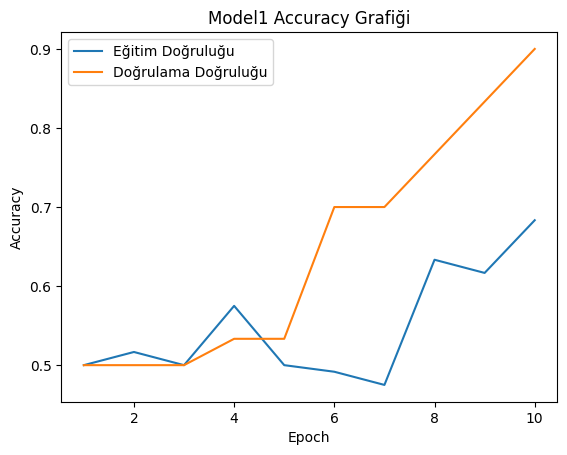

In [31]:
import matplotlib.pyplot as plt

acc = history1.history["accuracy"]
val_acc = history1.history["val_accuracy"]
epochs_range = range(1, len(acc)+1)

plt.plot(epochs_range, acc, label="Eğitim Doğruluğu")
plt.plot(epochs_range, val_acc, label="Doğrulama Doğruluğu")
plt.title("Model1 Accuracy Grafiği")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


12- Loss grafiği

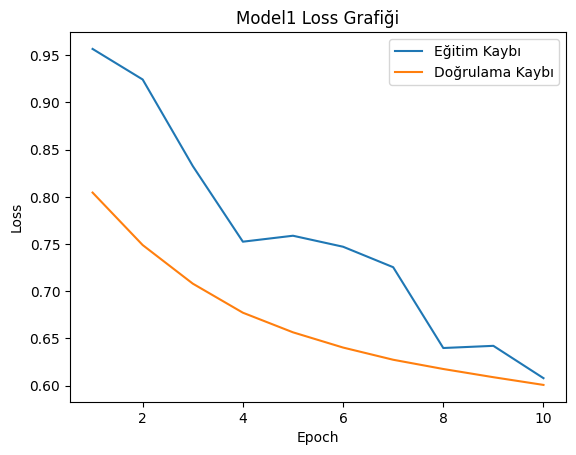

In [32]:
loss = history1.history["loss"]
val_loss = history1.history["val_loss"]

plt.plot(epochs_range, loss, label="Eğitim Kaybı")
plt.plot(epochs_range, val_loss, label="Doğrulama Kaybı")
plt.title("Model1 Loss Grafiği")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


13- Test (Validation) Doğruluğu Hesaplama

In [34]:
test_loss, test_acc = model1.evaluate(val_generator)
print("Model1 Test Doğruluğu:", test_acc)
print("Model1 Test Kaybı:", test_loss)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.9000 - loss: 0.6007
Model1 Test Doğruluğu: 0.8999999761581421
Model1 Test Kaybı: 0.6006807684898376
